<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v3)
This currently just has some small testing against a small improvement to the model code, but I'll probably later re-use it for more interesting things.

In [12]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at ea4d9dc Always outputting delta x/y/orientation with scaled values
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 5), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), 678.58 KiB | 7.30 MiB/s, done.
From https://github.com/malcolmlett/robovac
   ea4d9dc..7469608  main       -> origin/main
Updating ea4d9dc..7469608
Fast-forward
 Experiment_SLAM_2.ipynb | 430 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-
 Experiment_SLAM_3.ipynb | 360 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 slam_data.py            |  11 +-
 3 files changed, 792 insertions(+), 9 deletions(-)
 create mode 100644 Experiment_SLAM_3.ipynb


<module 'slam_data' from '/content/repo/slam_data.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00


In [3]:
# If generated data is available then load that to save time:
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data1.npz')

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from repo/data/experimental-slam-training-data1.npz


map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_341>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_347>]
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 614ms/step - adlo_output_accept_accuracy: 0.7112 - adlo_output_adlo_loss: 1.3503 - adlo_output_loc_error: 0.1769 - adlo_output_orientation_error: 0.0119 - loss: 2.1776 - map_output_accuracy: 0.6148 - map_output_loss: 0.8268
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 354ms/step - adlo_output_accept_accuracy: 0.7409 - adlo_output_adlo_loss: 0.5715 - adlo_output_loc_error: 0.0920 - 

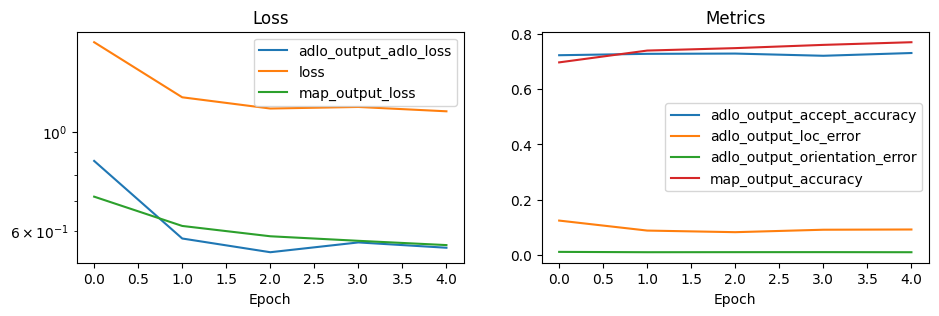

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.8256378e+00  5.7078052e-02 -2.1205232e-03 -8.7825648e-02]
adlo-pred scaled: [ 0.9970578   0.05707805 -0.00212052 -0.08782565]


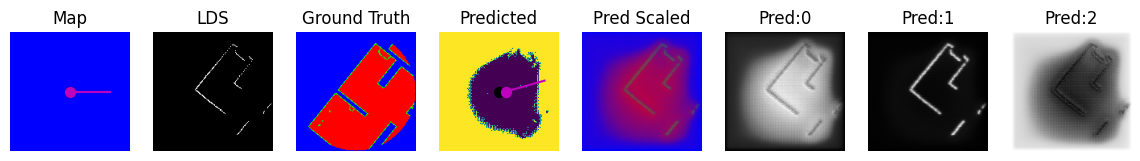

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [ 0.7413642   0.06228539  0.00753923 -0.0302509 ]
adlo-pred scaled: [ 0.6772941   0.06228539  0.00753923 -0.0302509 ]


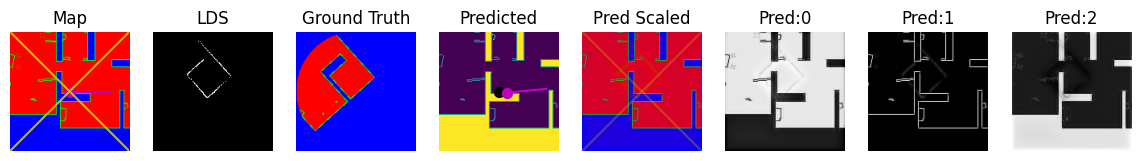

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [0.7253767  0.01455638 0.0059973  0.01129419]
adlo-pred scaled: [0.6737899  0.01455638 0.0059973  0.01129419]


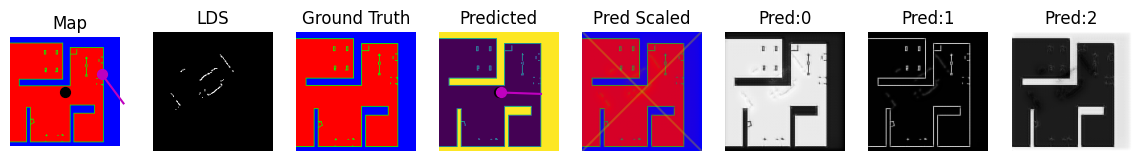

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.545493    0.04424298  0.00896488 -0.10921255]
adlo-pred scaled: [ 0.99611014  0.04424298  0.00896488 -0.10921255]


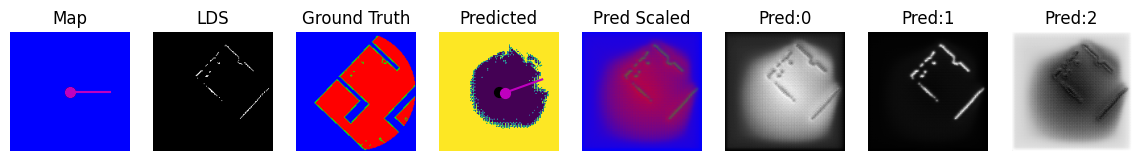

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [0.7421412  0.02331689 0.00696396 0.00555091]
adlo-pred scaled: [0.6774639  0.02331689 0.00696396 0.00555091]


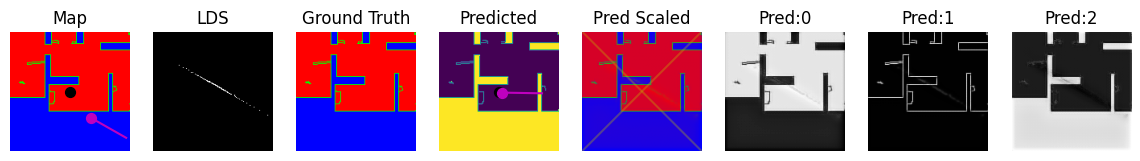

In [13]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': slam.ADLOLoss()
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })

epochs = 5
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')